In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import cv2
import re
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Plotting some images

Text(0.5, 1.0, 'wheat')

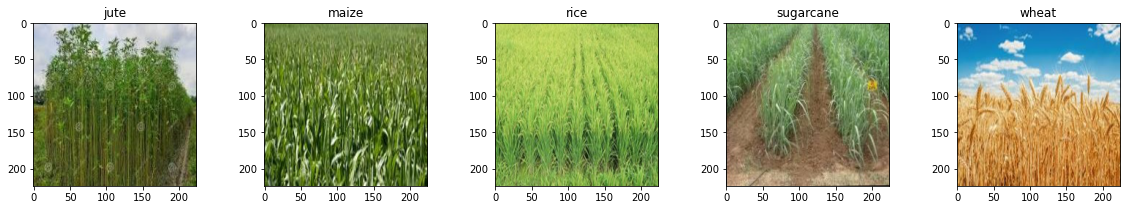

In [2]:
wheat = plt.imread("/kaggle/input/agriculture-crop-images/kag2/wheat/wheat0004a.jpeg")
jute = plt.imread("/kaggle/input/agriculture-crop-images/kag2/jute/jute005a.jpeg")
cane = plt.imread("/kaggle/input/agriculture-crop-images/kag2/sugarcane/sugarcane0010arot.jpeg")
rice = plt.imread("/kaggle/input/agriculture-crop-images/kag2/rice/rice032ahs.jpeg")
maize = plt.imread("/kaggle/input/agriculture-crop-images/kag2/maize/maize003a.jpeg")
plt.figure(figsize=(20,3))
plt.subplot(1,5,1)
plt.imshow(jute)
plt.title("jute")
plt.subplot(1,5,2)
plt.imshow(maize)
plt.title("maize")
plt.subplot(1,5,3)
plt.imshow(rice)
plt.title("rice")
plt.subplot(1,5,4)
plt.imshow(cane)
plt.title("sugarcane")
plt.subplot(1,5,5)
plt.imshow(wheat)
plt.title("wheat")

# Converting to training and testing data

In [3]:
jutepath = "../input/agriculture-crop-images/kag2/jute"
maizepath = "../input/agriculture-crop-images/kag2/maize"
ricepath = "../input/agriculture-crop-images/kag2/rice"
sugarcanepath = "../input/agriculture-crop-images/kag2/sugarcane"
wheatpath = "../input/agriculture-crop-images/kag2/wheat"

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)

X= []

In [4]:
for fname in jutefilename:
    X.append([os.path.join(jutepath,fname),0])
for fname in maizefilename:
    X.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X.append([os.path.join(sugarcanepath,fname),3]) 
for fname in wheatfilename:
    X.append([os.path.join(wheatpath,fname),4])  
X = pd.DataFrame(X,columns = ['path','labels'])    

In [5]:
X.head()

path  labels
0  ../input/agriculture-crop-images/kag2/jute/jut...       0
1  ../input/agriculture-crop-images/kag2/jute/jut...       0
2  ../input/agriculture-crop-images/kag2/jute/jut...       0
3  ../input/agriculture-crop-images/kag2/jute/jut...       0
4  ../input/agriculture-crop-images/kag2/jute/jut...       0

In [6]:
ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,ohlabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

In [7]:
train,test = train_test_split(new_X,test_size=0.2,random_state=0,shuffle = True)

In [8]:
X_train = train['path'].values
y_train = train.drop(['path'],axis=1).values
X_test = test['path'].values
y_test = test.drop(['path'],axis=1).values

In [9]:
def deep_pipeline(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)       
    return flat
    

In [10]:
dx_train = deep_pipeline(X_train)
dx_test = deep_pipeline(X_test)

# Model training

In [11]:
keras.backend.clear_session()
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5005      
Total params: 22,544,389
Trainable params: 2,520,005
Non-trainable params: 20,024,384
_________________________________________________________________


In [12]:
hist = vggmodel.fit(dx_train,y_train,epochs=40,validation_split=0.2,batch_size=32)

Epoch 1/40
16/16 [==============================] - 3s 197ms/step - loss: 3.3384 - accuracy: 0.2412 - val_loss: 1.9162 - val_accuracy: 0.2656
Epoch 2/40
16/16 [==============================] - 2s 128ms/step - loss: 1.2235 - accuracy: 0.4804 - val_loss: 1.2074 - val_accuracy: 0.5547
Epoch 3/40
16/16 [==============================] - 2s 129ms/step - loss: 0.9836 - accuracy: 0.6059 - val_loss: 1.0861 - val_accuracy: 0.5625
Epoch 4/40
16/16 [==============================] - 2s 128ms/step - loss: 0.8183 - accuracy: 0.6725 - val_loss: 1.1063 - val_accuracy: 0.5234
Epoch 5/40
16/16 [==============================] - 2s 127ms/step - loss: 0.6590 - accuracy: 0.7294 - val_loss: 0.8232 - val_accuracy: 0.7188
Epoch 6/40
16/16 [==============================] - 2s 125ms/step - loss: 0.5240 - accuracy: 0.7686 - val_loss: 0.9028 - val_accuracy: 0.6641
Epoch 7/40
16/16 [==============================] - 2s 123ms/step - loss: 0.4290 - accuracy: 0.8392 - val_loss: 0.6258 - val_accuracy: 0.7969
Epoch 

(0.0, 4.0)

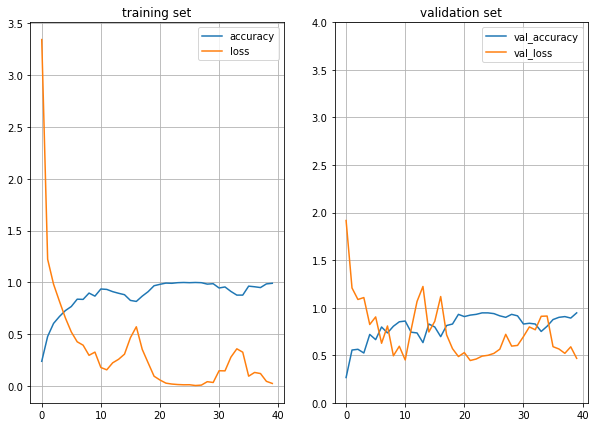

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.title("training set")
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.title("validation set")
plt.grid()
plt.ylim((0,4))

# Test Score

In [14]:
score = vggmodel.evaluate(dx_test,y_test)
print("accuracy: ", score[1])

5/5 [==============================] - 0s 75ms/step - loss: 0.3509 - accuracy: 0.9500
accuracy:  0.949999988079071


# Prediction Pipeline

In [15]:
def deepmodelpipeline(imagepath,model = vggmodel,label=[-1]):
    pdict = {0:"jute",1:"maize",2:"rice",3:"sugarcane",4:"wheat"}
    pred_x = deep_pipeline([imagepath])
    pred = np.argmax(model.predict(pred_x)[0])
    plt.imshow(plt.imread(imagepath))
    if (label[0]!=-1):
        plt.title("prediction : {} \ntrue        : {}".format(pdict[pred],pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {}".format(pdict[pred]))

# Prediction on sample images

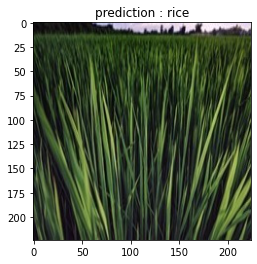

In [16]:
deepmodelpipeline('/kaggle/input/agriculture-crop-images/kag2/rice/rice024ahs.jpeg')

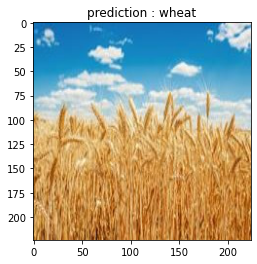

In [17]:
deepmodelpipeline('../input/agriculture-crop-images/kag2/wheat/wheat0004a.jpeg')

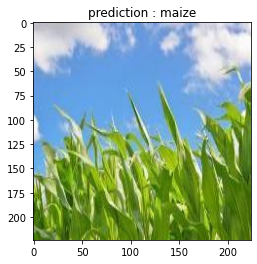

In [18]:
deepmodelpipeline("../input/agriculture-crop-images/kag2/maize/maize008ahf.jpeg")

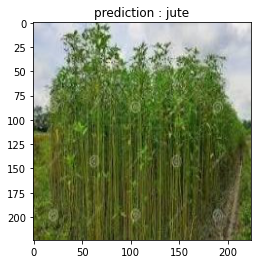

In [19]:
deepmodelpipeline("../input/agriculture-crop-images/kag2/jute/jute005a.jpeg")

# Prediction on test images

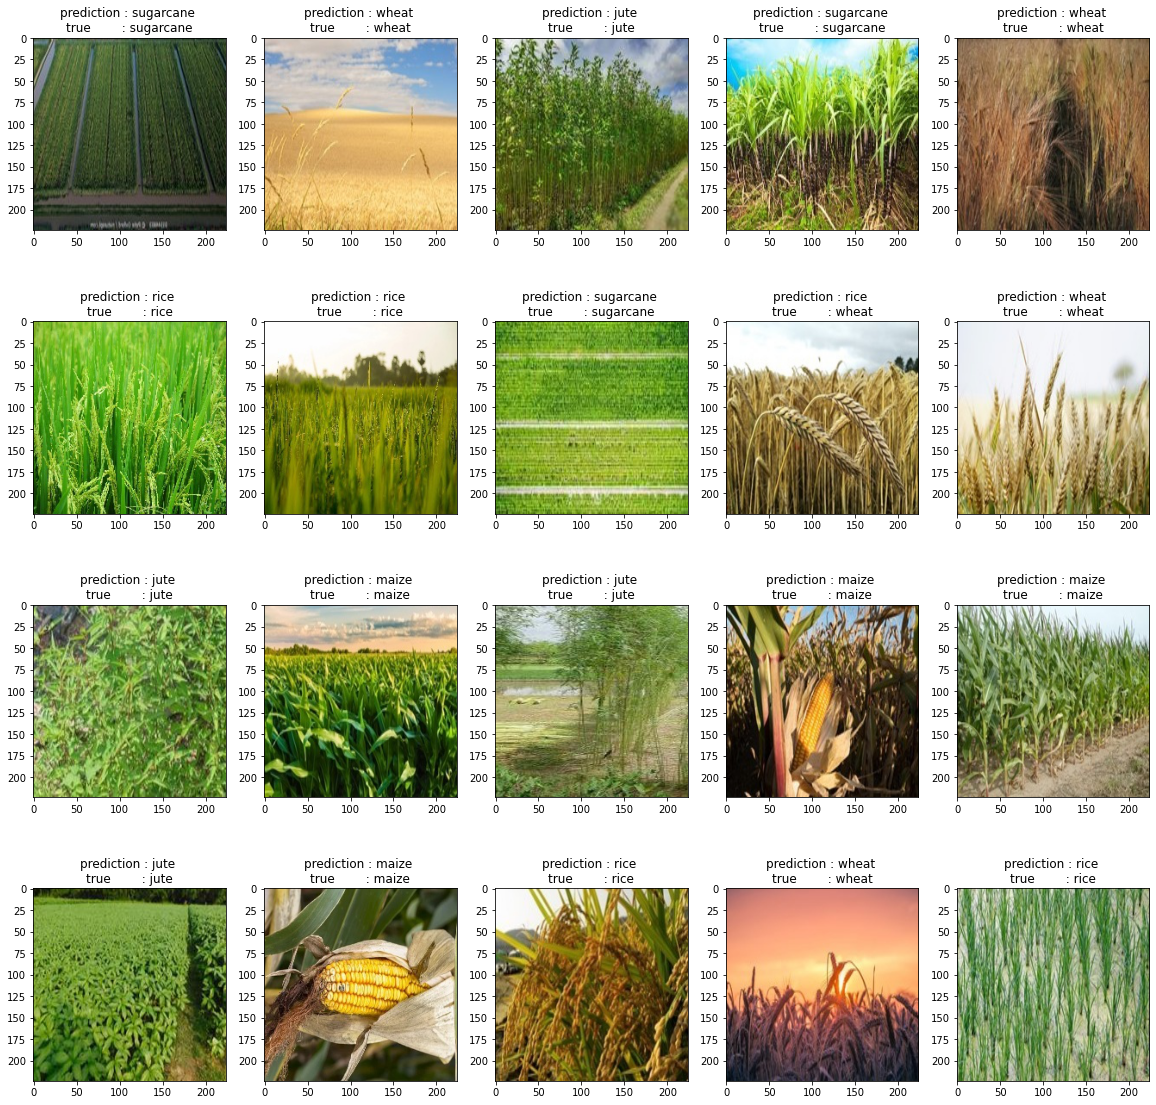

In [20]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[0:20]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num])

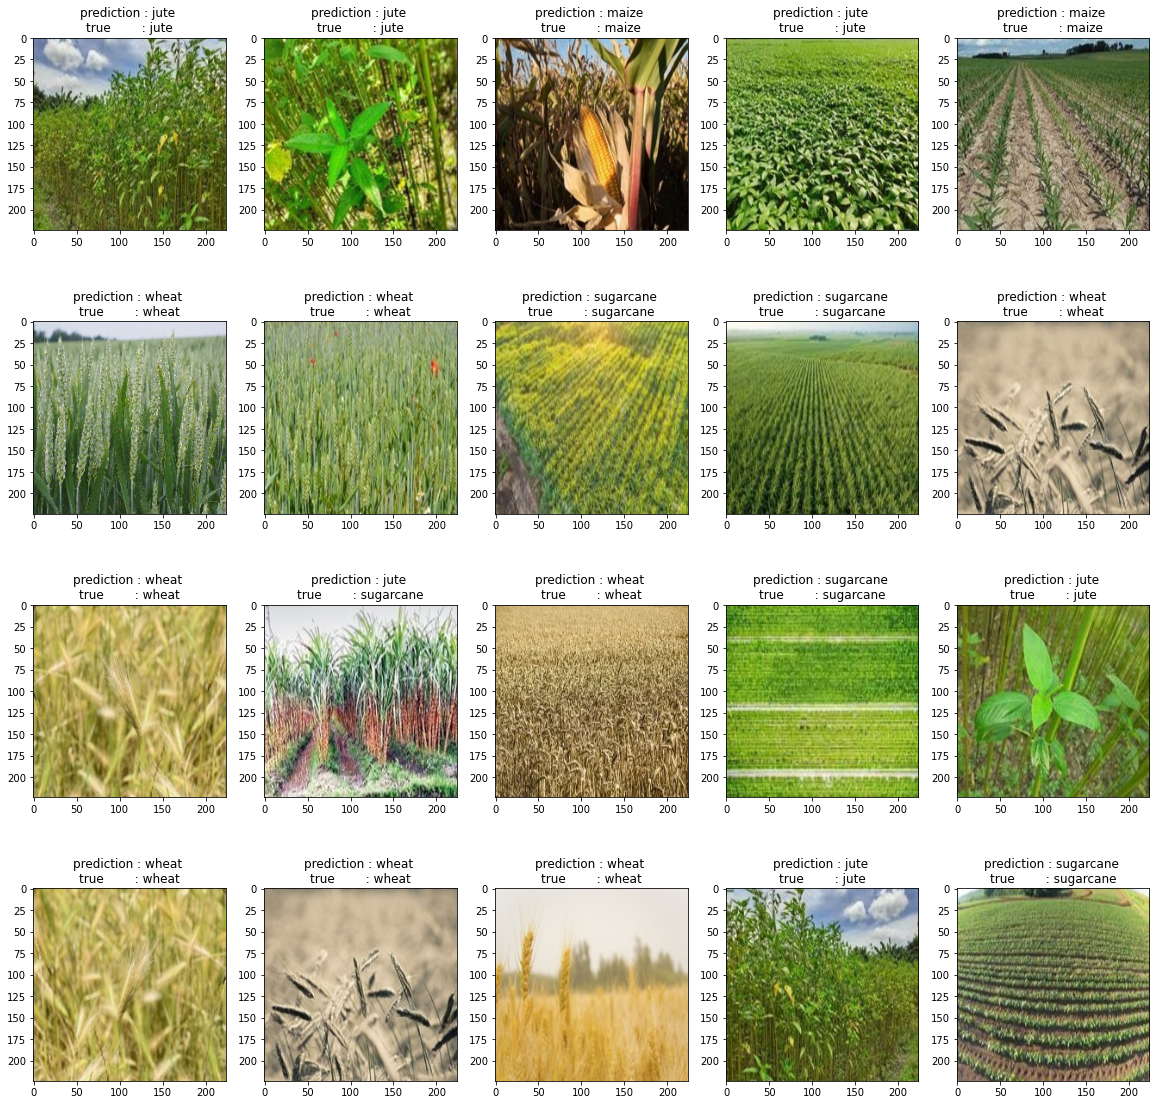

In [21]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[20:40]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num+20])

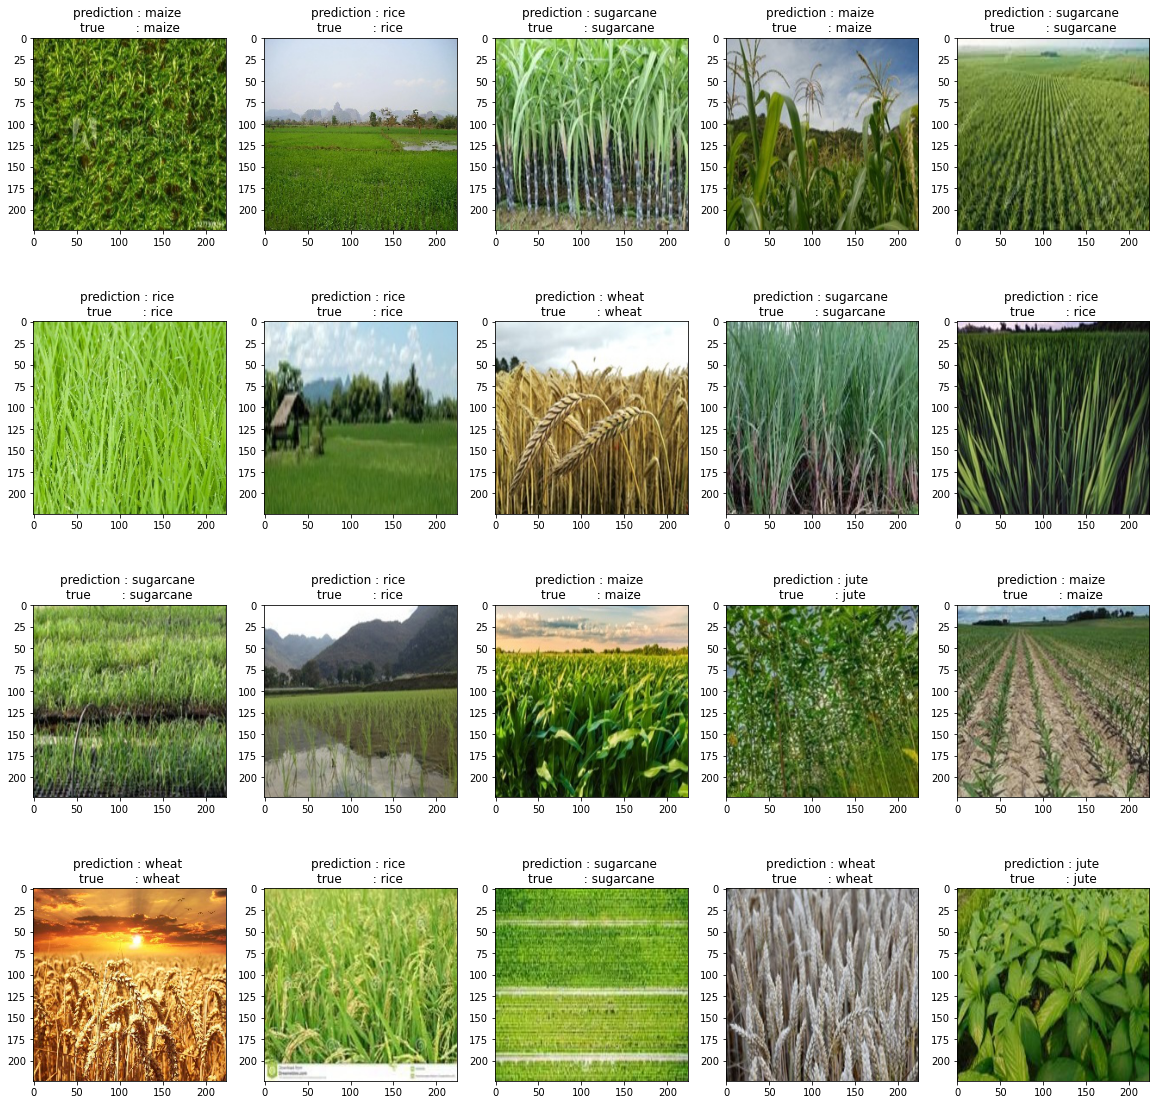

In [22]:
plt.figure(figsize=(20,20))
for num,path in enumerate(X_test[40:60]):
    plt.subplot(4,5,num+1)
    deepmodelpipeline(path,vggmodel,y_test[num+40])

# Saving model

In [23]:
vggmodel.save_weights("vggmodelweight.h5")